In [59]:
import os
import rasterio
import pandas as pd
import geopandas as gp
from matplotlib import pyplot as plt
from functools import reduce
from geopandas import GeoDataFrame
from shapely.geometry import Polygon, Point
from rasterio.features import shapes

## Funciones de procesamiento de datos

In [2]:
def get_date(tiff_path):
    tiff_name = tiff_path.split('/')[-1]
    date = '-'.join(tiff_name.split('.')[:-1])
    return date

In [3]:
def open_tiff(src, date, mask = None):
    results = []
    for s, v in shapes(src.read(), mask=mask, transform=src.meta['transform']):
        data = {
            'properties': {date: v}, 
            'geometry': Polygon(s['coordinates'][0]).centroid
        }
        results.append(data)
    return results

In [4]:
def get_raster(path):
    src = rasterio.open(path)
    crs = src.read_crs()
    date = get_date(path)
    tiff = open_tiff(src, date)
    src.close()
    raster = GeoDataFrame.from_features(tiff, crs=crs)
    raster['geometry'] = raster['geometry'].to_crs(crs)
    return raster

# Precipitaciones

In [138]:
folder = '../Datos/CHIRPS/'
rasters = []
for file in os.listdir(folder):
    if file.endswith('.tif'):
        path = os.path.join(folder, file)
        raster = get_raster(path)
        rasters.append(raster)

In [139]:
precipitaciones = reduce(lambda left, right: pd.merge(left, right, on='geometry', how='outer'), rasters)
print(precipitaciones.shape)
precipitaciones.fillna(0, inplace=True)
precipitaciones.head()

(86874, 9)


,geometry,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10
0,POINT (-83.32500 16.02500),3.575851,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,POINT (-84.90417 15.90833),0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,POINT (-84.77500 15.87500),29.857899,0.0,0.0,26.657270,0.0,0.0,0.0,0.0
3,POINT (-84.72500 15.87500),31.586699,0.0,0.0,27.568253,0.0,0.0,0.0,0.0
4,POINT (-84.67500 15.87500),25.088631,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## Agregar códigos de municipios y departamentos

In [140]:
municipios = gp.read_file('MGN_ANM_MPIOS.geojson')
municipios = municipios[['DPTO_CCDGO', 'MPIO_CCDGO', 'geometry']]
print(municipios.shape)
municipios.head()

(1122, 3)


,DPTO_CCDGO,MPIO_CCDGO,geometry
0,18,001,"POLYGON ((-75.40406 1.76950, -75.42726 1.75705..."
1,18,029,"POLYGON ((-75.75674 1.18908, -75.76613 1.18638..."
2,18,094,"POLYGON ((-75.77891 1.58257, -75.80857 1.53385..."
3,18,247,"POLYGON ((-75.34871 2.32353, -75.34474 2.31903..."
4,18,256,"POLYGON ((-74.96432 1.44361, -74.96652 1.44076..."


In [144]:
rain = gp.sjoin(precipitaciones, municipios, how='left', predicate='intersects')
rain = rain[rain['index_right'].notna()]
rain = rain.drop(columns=['index_right'])
print(rain.shape)
rain.head()

(35479, 11)


,geometry,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,DPTO_CCDGO,MPIO_CCDGO
194,POINT (-72.72500 11.67500),7.668361,4.612562,0.0,0.0,0.0,0.0,0.000000,0.0,44,560
195,POINT (-72.67500 11.67500),8.740595,0.000000,0.0,0.0,0.0,0.0,3.987114,0.0,44,560
196,POINT (-72.17500 11.67500),11.863071,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,44,847
198,POINT (-72.82500 11.62500),0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,44,560
199,POINT (-72.77500 11.62500),9.771236,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,44,560


In [145]:
plt.rcParams['figure.figsize'] = [12, 12]

<AxesSubplot:>

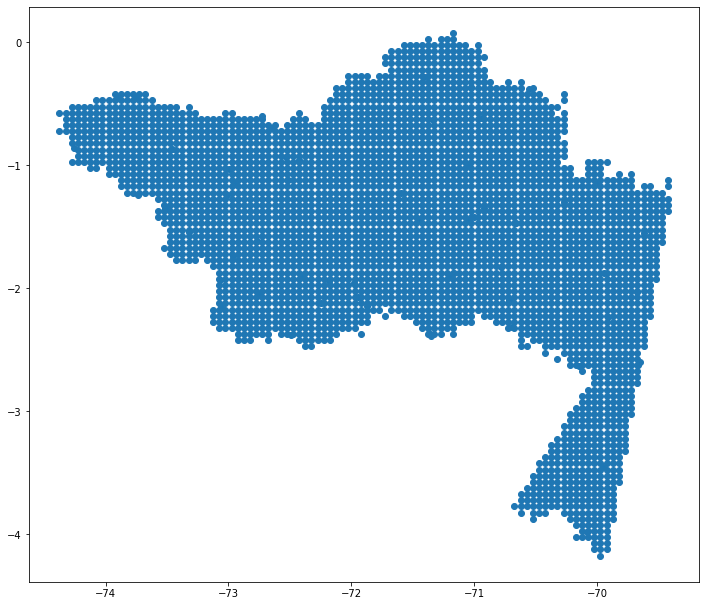

In [146]:
rain[rain.DPTO_CCDGO == '91'].plot()

## Exportar datos en formato GeoJSON

In [147]:
export_rain = GeoDataFrame(rain[['geometry', 'DPTO_CCDGO', 'MPIO_CCDGO']])
# Agrupar todas las precipitaciones por fecha en un solo campo
export_rain['precipitation'] = rain.drop(columns=['geometry', 'DPTO_CCDGO', 'MPIO_CCDGO']).to_dict('records')
# Exportar a GeoJSON
export_rain.to_file('precipitaciones.geojson', driver='GeoJSON')
export_rain.head()

,geometry,DPTO_CCDGO,MPIO_CCDGO,precipitation
194,POINT (-72.72500 11.67500),44,560,"{'2016-12-03': 7.668360710144043, '2016-12-04'..."
195,POINT (-72.67500 11.67500),44,560,"{'2016-12-03': 8.740594863891602, '2016-12-04'..."
196,POINT (-72.17500 11.67500),44,847,"{'2016-12-03': 11.86307144165039, '2016-12-04'..."
198,POINT (-72.82500 11.62500),44,560,"{'2016-12-03': 0.0, '2016-12-04': 0.0, '2016-1..."
199,POINT (-72.77500 11.62500),44,560,"{'2016-12-03': 9.771236419677734, '2016-12-04'..."


# Deslizamientos

In [148]:
deslizamientos = gp.read_file('INVENTARIO_FINAL_MM.csv')
deslizamientos.columns = ['movimiento', 'fecha', 'municipio', 'latitud', 'longitud', 'fuente', 'geometry']
deslizamientos.geometry = deslizamientos.apply(lambda row: Point(float(row['longitud']), float(row['latitud'])), axis=1)
print(deslizamientos.shape)

(1974, 7)


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [149]:
deslizamientos = deslizamientos[['geometry', 'movimiento', 'fecha', 'fuente']]
deslizamientos.fecha = pd.to_datetime(deslizamientos.fecha, format='%d/%m/%Y')
deslizamientos.set_crs(epsg=4326, inplace=True)
print(deslizamientos.shape)

(1974, 4)


In [150]:
deslizamientos = deslizamientos[deslizamientos.fecha >= '2010-01-01']
print(deslizamientos.shape)
deslizamientos.head()

(833, 4)


,geometry,movimiento,fecha,fuente
0,POINT (-73.58200 5.07500),Caida,2022-02-01,Catalogo SIMMA
1,POINT (-73.58400 5.07500),Deslizamiento,2022-02-01,Catalogo SIMMA
2,POINT (-74.38300 4.36800),Caida,2022-02-01,Catalogo SIMMA
3,POINT (-74.30285 4.90856),Caida,2022-02-01,Catalogo SIMMA
4,POINT (-73.62800 5.08700),Deslizamiento,2022-02-01,Catalogo SIMMA


<AxesSubplot:>

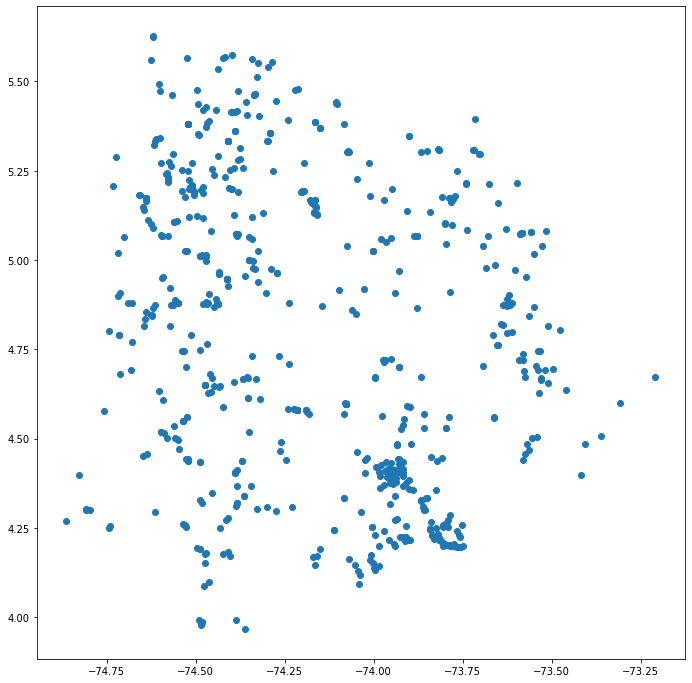

In [151]:
deslizamientos.geometry.plot()

In [152]:
# Obtener los municipios que contienen deslizamientos
geodata = gp.sjoin(deslizamientos, municipios, how='left', predicate='intersects')
geodata = geodata[geodata['index_right'].notna()]
geodata = geodata.drop(columns=['index_right'])
print(geodata.shape)

# Exportar a GeoJSON
geodata.to_file('deslizamientos.geojson', driver='GeoJSON')
geodata.head()

(833, 6)


,geometry,movimiento,fecha,fuente,DPTO_CCDGO,MPIO_CCDGO
0,POINT (-73.58200 5.07500),Caida,2022-02-01,Catalogo SIMMA,25,426
1,POINT (-73.58400 5.07500),Deslizamiento,2022-02-01,Catalogo SIMMA,25,426
2,POINT (-74.38300 4.36800),Caida,2022-02-01,Catalogo SIMMA,25,290
3,POINT (-74.30285 4.90856),Caida,2022-02-01,Catalogo SIMMA,25,402
4,POINT (-73.62800 5.08700),Deslizamiento,2022-02-01,Catalogo SIMMA,25,426
